# Testing Model on VRPLib

In this notebook, we will test the trained model's performance on the VRPLib benchmark.

[VRPLib](http://vrp.galgos.inf.puc-rio.br/index.php/en/) is a collection of instances related to the CVRP, which is a classic optimization challenge in the field of logistics and transportation. 

<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/examples/datasets/2-test-on-cvrplib.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

## Installation

Uncomment the following line to install the package from PyPI. Remember to choose a GPU runtime for faster training!

> Note: You may need to restart the runtime in Colab after this


In [ ]:
# !pip install rl4co[graph] # include torch-geometric
# !pip install vrplib # for reading instance files

## NOTE: to install latest version from Github (may be unstable) install from source instead:
# !pip install git+https://github.com/ai4co/rl4co.git

In [2]:
# Install the `vrplib` package
# !pip install vrplib

## Imports

In [3]:
%load_ext autoreload
%autoreload 2

import os
import torch
import vrplib
from tensordict import TensorDict

from rl4co.envs import CVRPEnv
from rl4co.models.zoo.am import AttentionModelPolicy
from rl4co.models.rl import REINFORCE
from rl4co.utils.trainer import RL4COTrainer

from tqdm import tqdm

/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/pkg_resources/__init__.py:3144: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/fabric/__init__.py:41: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/home

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RL4CO env based on TorchRL
env = CVRPEnv(generator_params={'num_loc': 50})

# Policy: neural network, in this case with encoder-decoder architecture
policy = AttentionModelPolicy(env_name=env.name).to(device)

# RL Model: REINFORCE and greedy rollout baseline
model = REINFORCE(env, 
                    policy,
                    baseline="rollout",
                    batch_size=512,
                    train_data_size=100_000,
                    val_data_size=10_000,
                    optimizer_kwargs={"lr": 1e-4},
                    ) 

/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


## Download vrp problems

In [5]:
problem_names = vrplib.list_names(low=50, high=100, vrp_type='cvrp') 

instances = [] # Collect Set A, B, E, F, M datasets
for name in problem_names:
    if 'A' in name:
        instances.append(name)
    elif 'B' in name:
        instances.append(name)
    elif 'E' in name:
        instances.append(name)
    elif 'F' in name:
        instances.append(name)
    elif 'M' in name and 'CMT' not in name:
        instances.append(name)

# Modify the path you want to save 
# Note: we don't have to create this folder in advance
path_to_save = './vrplib/' 

try:
    os.makedirs(path_to_save)
    for instance in tqdm(instances):
        vrplib.download_instance(instance, path_to_save)
        vrplib.download_solution(instance, path_to_save)
except: # already exist
    pass 

/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/vrplib/download/list_names.py:58: DeprecationWarning: read_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  fi = pkg_resource.read_text(__package__, "instance_data.csv")
/home/botu/mambaforge/envs/rl4co/lib/python3.11/importlib/resources/_legacy.py:80: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  with open_text(package, resource, encoding, errors) as fp:
/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/vrplib/download/list_names.py:32: DeprecationWarning: The function 'list_names' is deprecated and will be removed in the next major version (vrplib v2.0.0).
  warnings.warn(msg, DeprecationWarning)


In [6]:
# Utils function: we will normalize the coordinates of the VRP instances
def normalize_coord(coord:torch.Tensor) -> torch.Tensor:
    x, y = coord[:, 0], coord[:, 1]
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    
    x_scaled = (x - x_min) / (x_max - x_min) 
    y_scaled = (y - y_min) / (y_max - y_min)
    coord_scaled = torch.stack([x_scaled, y_scaled], dim=1)
    return coord_scaled 

def vrplib_to_td(problem, normalize=True):
    coords = torch.tensor(problem['node_coord']).float()
    coords_norm = normalize_coord(coords) if normalize else coords
    demand = torch.tensor(problem['demand'][1:]).float()
    capacity = problem['capacity']
    n = coords.shape[0]
    td = TensorDict({
        'depot': coords_norm[0,:],
        'locs': coords_norm[1:,:],
        'demand': demand / capacity, # normalized demand
        'capacity': capacity, # original capacity, not needed for inference
    })
    td = td[None] # add batch dimension, in this case just 1
    return td

## Test untrained

In [8]:
tds, actions = [], []
for instance in instances:
    # Inference
    problem = vrplib.read_instance(os.path.join(path_to_save, instance+'.vrp'))
    td_reset = env.reset(vrplib_to_td(problem).to(device))
    with torch.inference_mode():
        out = policy(td_reset.clone(), env, decode_type="sampling", num_samples=128, select_best=True)
        unnormalized_td = env.reset(vrplib_to_td(problem, normalize=False).to(device))
        cost = -env.get_reward(unnormalized_td, out["actions"]).int().item() # unnormalized cost
        
    # Load the optimal cost
    solution = vrplib.read_solution(os.path.join(path_to_save, instance+'.sol'))
    optimal_cost = solution['cost']

    tds.append(td_reset)
    actions.append(out["actions"])
    
    # Calculate the gap and print
    gap = (cost - optimal_cost) / optimal_cost
    print(f'Problem: {instance:<15} Cost: {cost:<8} BKS: {optimal_cost:<8}\t Gap: {gap:.2%}')

Problem: A-n53-k7        Cost: 2777     BKS: 1010    	 Gap: 174.95%
Problem: A-n54-k7        Cost: 3130     BKS: 1167    	 Gap: 168.21%
Problem: A-n55-k9        Cost: 2812     BKS: 1073    	 Gap: 162.07%
Problem: A-n60-k9        Cost: 3151     BKS: 1354    	 Gap: 132.72%
Problem: A-n61-k9        Cost: 3060     BKS: 1034    	 Gap: 195.94%
Problem: A-n62-k8        Cost: 3483     BKS: 1288    	 Gap: 170.42%
Problem: A-n63-k9        Cost: 3736     BKS: 1616    	 Gap: 131.19%
Problem: A-n63-k10       Cost: 3110     BKS: 1314    	 Gap: 136.68%
Problem: A-n64-k9        Cost: 3721     BKS: 1401    	 Gap: 165.60%
Problem: A-n65-k9        Cost: 3548     BKS: 1174    	 Gap: 202.21%
Problem: A-n69-k9        Cost: 3600     BKS: 1159    	 Gap: 210.61%
Problem: A-n80-k10       Cost: 4776     BKS: 1763    	 Gap: 170.90%
Problem: B-n51-k7        Cost: 3286     BKS: 1032    	 Gap: 218.41%
Problem: B-n52-k7        Cost: 2852     BKS: 747     	 Gap: 281.79%
Problem: B-n56-k7        Cost: 2762     BKS: 707

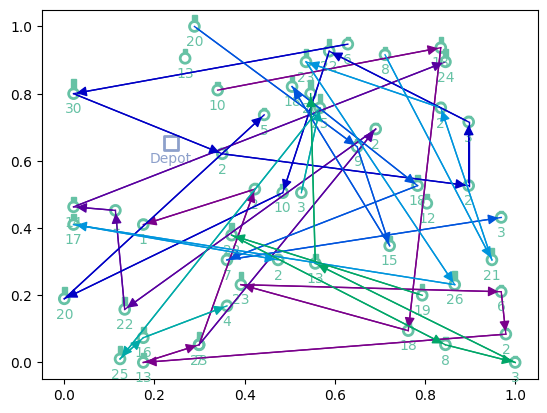

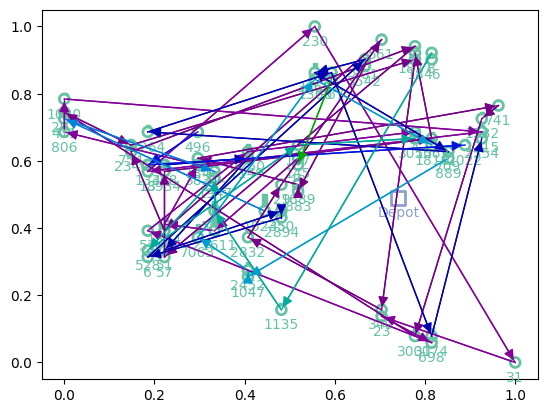

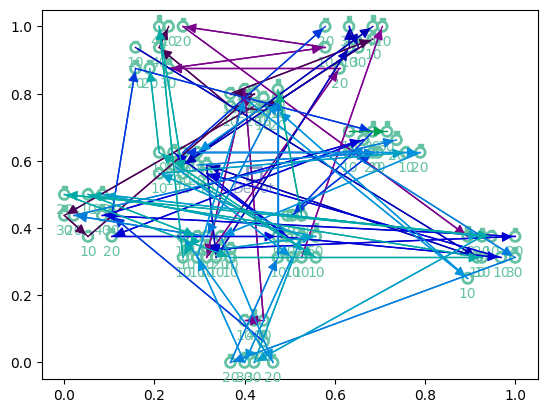

In [ ]:
# Plot some instances
env.render(tds[0], actions[0].cpu())
env.render(tds[-2], actions[-2].cpu())
env.render(tds[-1], actions[-1].cpu())

### Train

We will train for few steps just to show the effects of training a model.
Alternatively, we can load the a pretrained checkpoint, e.g. with:

```python
model = AttentionModel.load_from_checkpoint(checkpoint_path, load_baseline=False)
```


In [10]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None,
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/plugins/precision/amp.py:55: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | CVRPEnv              | 0     
1 | policy   | AttentionModelPolicy | 694 K 
2 | baseline | WarmupBaseline       | 694 K 
--------------------------------------------------
1.4 M     Trainable params
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


### Test trained model

In [11]:
policy = model.policy.to(device).eval() # trained policy

tds, actions = [], []
for instance in instances:
    # Inference
    problem = vrplib.read_instance(os.path.join(path_to_save, instance+'.vrp'))
    td_reset = env.reset(vrplib_to_td(problem).to(device))
    with torch.inference_mode():
        out = policy(td_reset.clone(), env, decode_type="sampling", num_samples=128, select_best=True)
        unnormalized_td = env.reset(vrplib_to_td(problem, normalize=False).to(device))
        cost = -env.get_reward(unnormalized_td, out["actions"]).int().item() # unnormalized cost
        
    # Load the optimal cost
    solution = vrplib.read_solution(os.path.join(path_to_save, instance+'.sol'))
    optimal_cost = solution['cost']

    tds.append(td_reset)
    actions.append(out["actions"])
    
    # Calculate the gap and print
    gap = (cost - optimal_cost) / optimal_cost
    print(f'Problem: {instance:<15} Cost: {cost:<8} BKS: {optimal_cost:<8}\t Gap: {gap:.2%}')

Problem: A-n53-k7        Cost: 1180     BKS: 1010    	 Gap: 16.83%
Problem: A-n54-k7        Cost: 1256     BKS: 1167    	 Gap: 7.63%
Problem: A-n55-k9        Cost: 1195     BKS: 1073    	 Gap: 11.37%
Problem: A-n60-k9        Cost: 1502     BKS: 1354    	 Gap: 10.93%
Problem: A-n61-k9        Cost: 1223     BKS: 1034    	 Gap: 18.28%
Problem: A-n62-k8        Cost: 1491     BKS: 1288    	 Gap: 15.76%
Problem: A-n63-k9        Cost: 1792     BKS: 1616    	 Gap: 10.89%
Problem: A-n63-k10       Cost: 1459     BKS: 1314    	 Gap: 11.04%
Problem: A-n64-k9        Cost: 1537     BKS: 1401    	 Gap: 9.71%
Problem: A-n65-k9        Cost: 1355     BKS: 1174    	 Gap: 15.42%
Problem: A-n69-k9        Cost: 1317     BKS: 1159    	 Gap: 13.63%
Problem: A-n80-k10       Cost: 2009     BKS: 1763    	 Gap: 13.95%
Problem: B-n51-k7        Cost: 1182     BKS: 1032    	 Gap: 14.53%
Problem: B-n52-k7        Cost: 863      BKS: 747     	 Gap: 15.53%
Problem: B-n56-k7        Cost: 889      BKS: 707     	 Gap: 25.7

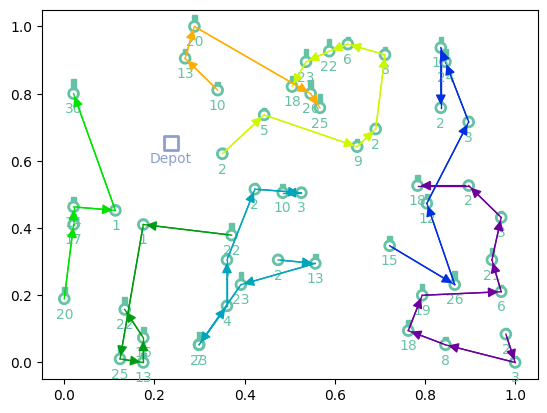

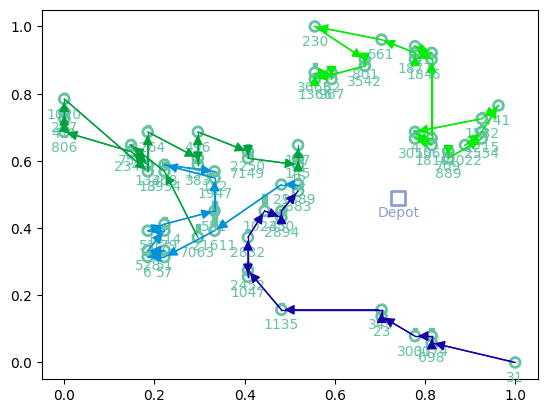

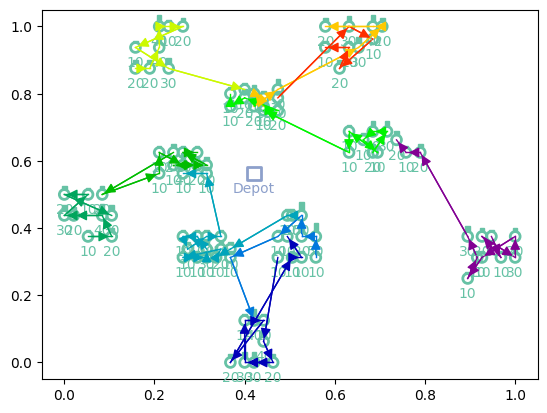

In [12]:
# Plot some instances
env.render(tds[0], actions[0].cpu())
env.render(tds[-2], actions[-2].cpu())
env.render(tds[-1], actions[-1].cpu())

Great! We can see that the performance vastly improved even with just few minutes of training.

There are several ways to improve the model's performance further, such as:
- Training for more steps
- Using a different model architecture
- Using a different training algorithm
- Using a different hyperparameters
- Using a different `Generator` 
- ... and many more!